In [112]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import table
import time


def get_summary_df(df):
    dfd=df.describe()
    
    tmp=[dfd["mean":"mean"],dfd["max":"max"],dfd["min":"min"]]
    dfx=pd.concat(tmp)
    dfx=dfx.applymap(lambda x:np.round(x,4))
    return dfx
    
l=time.localtime()[0:3]
today="/".join(map(str,l))

df=pd.read_csv("boinc_perf.csv")
del df["taskid"]
#print(df.describe())
df=df[(df["cputime_diff"]>0) & (df["walltime_diff"]>0)]
df=df[(df["cputime_diff"]<3600) & (df["walltime_diff"]<3600)]
df=df[df["panda_cpusec_perjob"]<240000]
df["cpu_percore"]=(df["panda_cpusec_perjob"]/(df["ncore"]*60))

df["cpu_percore"]=df["cpu_percore"].map(int)
print("cpu_percore",df["cpu_percore"].describe())
df["cputime_diff"]=(df["cputime_diff"]/df["ncore"])
df["walltime_diff"]=(df["walltime_diff"]/df["ncore"])
df["av"]=df["av"].map(lambda x: "native" if x==478 else "vm")
jobs_total=df["boinc_cn"].sum()
hosts_native=len(df[df["av"]=="native"].values)
hosts_vm=len(df[df["av"]=="vm"].values)
jobs_native=df[df["av"]=="native"]["boinc_cn"].sum()
jobs_vm=jobs_total-jobs_native
print("before trimming, %d total jobs, %d vm jobs from %d vm hosts, and %d native jobs from %d native hosts"\
      %(jobs_total,jobs_vm,hosts_vm,jobs_native,hosts_native))


print("cpu_percore values",df["cpu_percore"].values)
df=df.sort_values(by=["cpu_percore","av"])
df.set_index("cpu_percore",inplace=True)
df=df.sort_index()
print("index:",df.index.values)
print(df.describe())
#df=df[(df["panda_cpu_eff"]-df["boinc_cpu_eff"])<=0.5/df["cpu_percore"]]
#df=df[df["boinc_cn"]==df["panda_cn"]]


del df['Unnamed: 0']
del df["host"]
del df["ncore"]
del df["panda_cpusec_perjob"]
df=df[df["boinc_cpu_eff"]<df["panda_cpu_eff"]]

jobs_total=df["boinc_cn"].sum()
hosts_native=len(df[df["av"]=="native"].values)
hosts_vm=len(df[df["av"]=="vm"].values)
jobs_native=df[df["av"]=="native"]["boinc_cn"].sum()
jobs_vm=jobs_total-jobs_native
print("after trimming, %d total jobs, %d vm jobs from %d vm hosts, and %d native jobs from %d native hosts"\
      %(jobs_total,jobs_vm,hosts_vm,jobs_native,hosts_native))
#print(df[df["cpu_percore"]==0])







cpu_percore count    13179.000000
mean       235.660217
std        162.117259
min         18.000000
25%        128.000000
50%        196.000000
75%        291.000000
max       2987.000000
Name: cpu_percore, dtype: float64
before trimming, 123369 total jobs, 83752 vm jobs from 11236 vm hosts, and 39617 native jobs from 1943 native hosts
cpu_percore values [216 262 280 ... 217 278 184]
index: [  18   19   19 ... 2478 2488 2987]
         Unnamed: 0         ncore      panda_cn      boinc_cn  \
count  13179.000000  13179.000000  13179.000000  13179.000000   
mean    8103.337127      4.761135      9.361029      9.361029   
std     4672.231346      2.251154     17.067964     17.067964   
min        2.000000      1.000000      1.000000      1.000000   
25%     4078.500000      4.000000      3.000000      3.000000   
50%     8125.000000      4.000000      5.000000      5.000000   
75%    12106.500000      4.000000     10.000000     10.000000   
max    16252.000000     12.000000    352.000000   

/usr/lib64/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


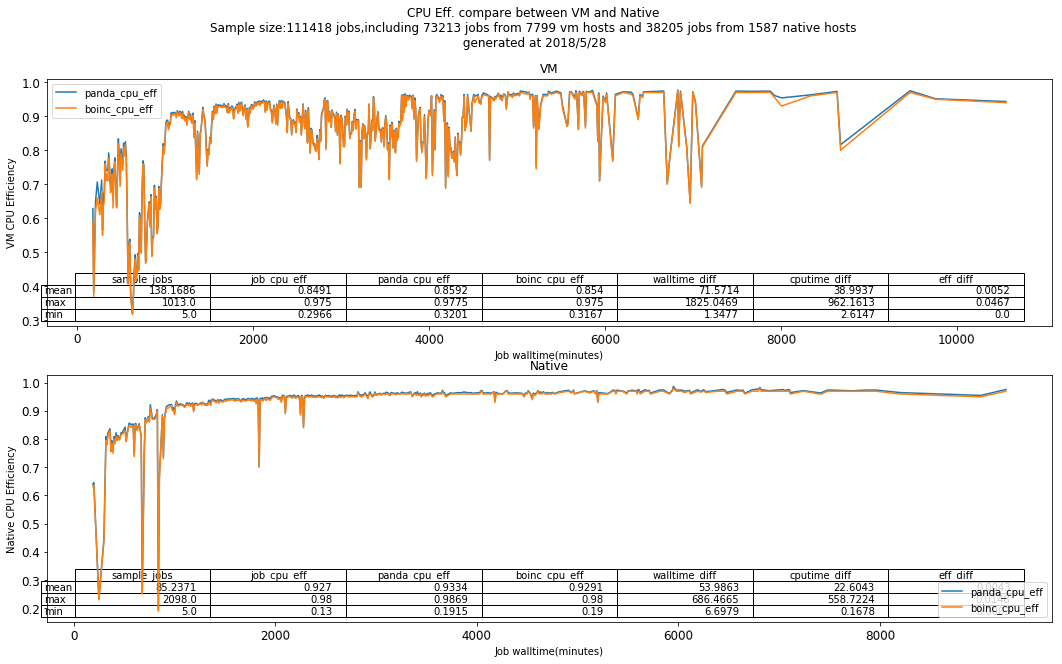

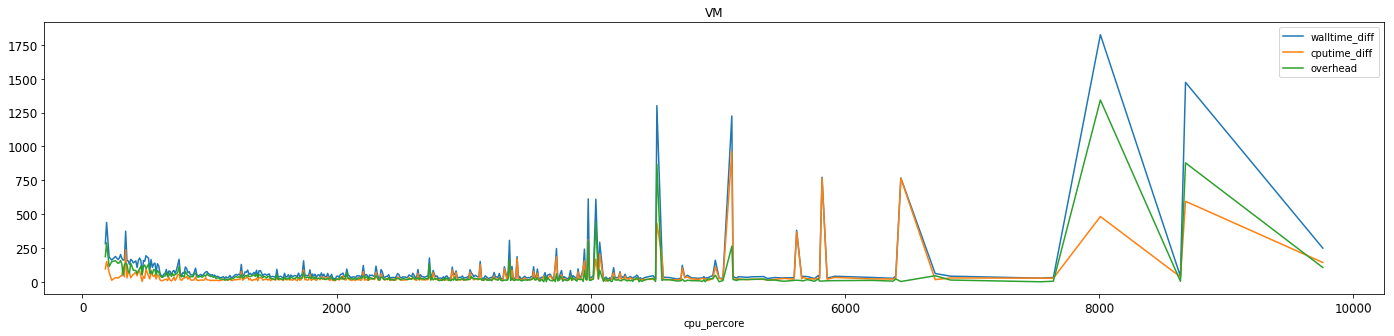

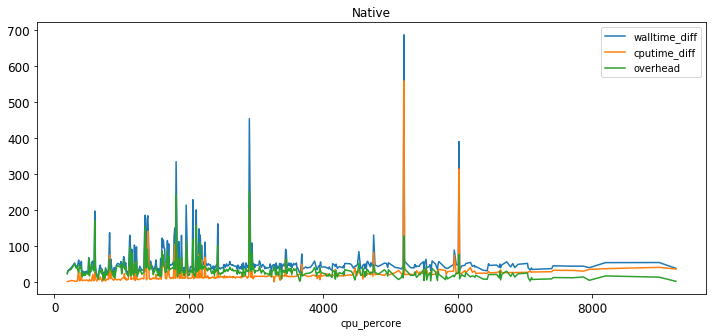

In [113]:
dlist=[]
grouped=df.groupby(["av","cpu_percore"])
for name,group in grouped:
    g=group[["job_cpu_eff","panda_cpu_eff","boinc_cpu_eff","walltime_diff","cputime_diff"]].mean()
    s=group[["panda_cn","boinc_cn"]].sum()
    d=[]
    for i in name:
        if i not in ["vm","native"]:
            cpu_percore=i
        else:
            type=i
    if s["panda_cn"]<5 or s["boinc_cn"]<5:
        continue
    d=[type,cpu_percore,s["panda_cn"],g["job_cpu_eff"],g["panda_cpu_eff"],g["boinc_cpu_eff"],g["walltime_diff"],g["cputime_diff"]]
    dlist.append(d)

head=["type","cpu_percore","sample_jobs","job_cpu_eff","panda_cpu_eff","boinc_cpu_eff","walltime_diff","cputime_diff"]
df2=pd.DataFrame(dlist,columns=head)
df2=df2.sort_values(by=["cpu_percore"]).set_index("cpu_percore")

grouped=df2.groupby(["type","cpu_percore"])
dlist=[]
for name,group in grouped:
    d=[]
    for i in name:
        d.append(i)
    g=group[["job_cpu_eff","panda_cpu_eff","boinc_cpu_eff","walltime_diff","cputime_diff"]].mean()
    total_jobs=group[["sample_jobs"]].sum()["sample_jobs"]
    d.append(total_jobs)
    d.append(g["job_cpu_eff"])
    d.append(g["panda_cpu_eff"])
    d.append(g["boinc_cpu_eff"])
    d.append(g["walltime_diff"])
    d.append(g["cputime_diff"])
    
    dlist.append(d)

df3=pd.DataFrame(dlist,columns=head)
df3["cpu_percore"]=df3["cpu_percore"].map(lambda x:x*10)
df3.sort_values(by=["cpu_percore"])
#del df3["job_cpu_eff"]

df_native=df3[df3["type"]=="native"]
df_vm=df3[df3["type"]=="vm"]


df6=df_native.copy()
df6["native_eff"]=df6["boinc_cpu_eff"]
del df6["boinc_cpu_eff"]
del df6["panda_cpu_eff"]
del df6["type"]
df7=df_vm.copy()
df7["vm_eff"]=df7["boinc_cpu_eff"]
del df7["boinc_cpu_eff"]
del df7["panda_cpu_eff"]
del df7["type"]
df_merge=df6.merge(df7,on="cpu_percore",how="inner")
df_merge["eff_diff"]=df_merge["native_eff"]-df_merge["vm_eff"]
df_merge=df_merge.set_index("cpu_percore")


df_native=df_native.set_index("cpu_percore")
df_vm=df_vm.set_index("cpu_percore")
df_native["eff_diff"]=df_native["panda_cpu_eff"]-df_native["boinc_cpu_eff"]
df_vm["eff_diff"]=df_vm["panda_cpu_eff"]-df_vm["boinc_cpu_eff"]


dfes=[df_vm,df_native]
#print(df_vm)
#print(df_native)
#print(get_summary_df(dfes[0]))
fig, axes = plt.subplots(2,1)

plt.suptitle("CPU Eff. compare between VM and Native\nSample size:%d jobs,including %d jobs from %d vm hosts and %d jobs \
from %d native hosts\n generated at %s"%(jobs_total,jobs_vm,hosts_vm,jobs_native,hosts_native,today))
for i in [0,1]:
    plt.legend(loc="upper left")
    tag="Native"
    if i==0:
        tag="VM"
    dfes[i][["panda_cpu_eff","boinc_cpu_eff"]].plot(ax=axes[i],kind="line",grid=False,figsize=(18,10),\
                                                    rot=1,fontsize=12,title=tag,alpha=1)
    table(axes[i],get_summary_df(dfes[i]),loc="lower center",colWidths=[0.135]*len(dfes[i].columns),fontsize=12)
    axes[i].set_xlabel("Job walltime(minutes)")
    axes[i].set_ylabel("%s CPU Efficiency"%tag)
    
    #ax.get_xaxis().set_visible(False)

fig.savefig("boinc_native_perf.png")
df_vm["overhead"]=df_vm["walltime_diff"]-df_vm["cputime_diff"]
df_vm=df_vm[(df_vm["overhead"]>0)]

df_native["overhead"]=df_native["walltime_diff"]-df_native["cputime_diff"]
df_native=df_native[(df_native["overhead"]>0)]
df_vm[["walltime_diff","cputime_diff","overhead"]].plot(kind="line",grid=False,figsize=(24,5),rot=1,fontsize=12,title="VM",alpha=1)
df_native[["walltime_diff","cputime_diff","overhead"]].plot(kind="line",grid=False,figsize=(12,5),\
                rot=1,fontsize=12,title="Native",alpha=1)

In [116]:
print(df_vm.iloc[1:41][["overhead"]].describe())
#df_vm["loss"]=df_vm["overhead"]/(df_vm["cpu_percore"]*60)
#print(df_vm.iloc[1:41][["loss"]].describe())

print(df_vm.columns,df_vm.index.values)
df_vm.iloc[1:20]

         overhead
count   40.000000
mean    98.320914
std     47.820105
min     32.341427
25%     62.100366
50%     88.884217
75%    129.919485
max    288.260243
Index(['type', 'sample_jobs', 'job_cpu_eff', 'panda_cpu_eff', 'boinc_cpu_eff',
       'walltime_diff', 'cputime_diff', 'eff_diff', 'overhead'],
      dtype='object') [ 180  190  210  230  260  280  290  300  310  320  330  340  350  360
  370  380  390  400  420  430  440  450  460  470  480  490  500  520
  530  540  550  560  570  580  590  600  610  620  630  640  650  660
  670  680  690  700  710  720  730  740  750  760  770  780  790  800
  810  820  830  840  850  860  870  880  890  900  910  920  930  940
  950  960  970  980  990 1000 1010 1020 1030 1040 1050 1060 1070 1080
 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220
 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360
 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500
 1510 1520 1530 1540 1550 1560 15

,type,sample_jobs,job_cpu_eff,panda_cpu_eff,boinc_cpu_eff,walltime_diff,cputime_diff,eff_diff,overhead
cpu_percore,,,,,,,,,
190,vm,12,0.340000,0.381667,0.370000,438.952754,150.692510,0.011667,288.260243
210,vm,35,0.590000,0.646571,0.620000,182.957895,70.538679,0.026571,112.419216
230,vm,6,0.650000,0.706667,0.660000,160.382200,11.658750,0.046667,148.723450
260,vm,51,0.600000,0.641840,0.610000,187.098252,31.215322,0.031840,155.882930
280,vm,16,0.670000,0.712500,0.680000,164.078472,27.929219,0.032500,136.149253
290,vm,30,0.535000,0.566207,0.550000,174.870321,34.292112,0.016207,140.578209
300,vm,15,0.620000,0.662593,0.633333,201.455794,43.406928,0.029259,158.048867
310,vm,136,0.640000,0.680538,0.653333,173.993122,43.481717,0.027205,130.511406
320,vm,108,0.720000,0.767963,0.760000,160.146617,110.379884,0.007963,49.766732


In [115]:
print(df_native.iloc[1:41][["overhead"]].describe())
print(df_native.columns,df_native.index.values)
df_native.head(20)

         overhead
count   40.000000
mean    32.877790
std     25.412315
min      5.260913
25%     21.736332
50%     30.435408
75%     36.962850
max    170.322481
Index(['type', 'sample_jobs', 'job_cpu_eff', 'panda_cpu_eff', 'boinc_cpu_eff',
       'walltime_diff', 'cputime_diff', 'eff_diff', 'overhead'],
      dtype='object') [ 190  200  250  300  320  330  340  360  370  380  390  400  410  420
  430  440  450  460  470  480  490  500  510  520  530  540  550  570
  580  590  600  610  620  630  650  670  680  700  710  720  730  740
  750  760  780  800  810  820  830  840  850  880  890  900  920  940
  970  980  990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100
 1110 1120 1130 1140 1150 1160 1180 1190 1200 1210 1220 1230 1260 1270
 1280 1300 1330 1340 1350 1360 1370 1380 1390 1410 1420 1430 1440 1450
 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590
 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730
 1740 1750 1760 1770 1780 1790 18

,type,sample_jobs,job_cpu_eff,panda_cpu_eff,boinc_cpu_eff,walltime_diff,cputime_diff,eff_diff,overhead
cpu_percore,,,,,,,,,
190,native,2098,0.628750,0.639453,0.631250,23.853685,1.101519,0.008203,22.752166
200,native,1492,0.630000,0.645754,0.636667,31.431133,1.535839,0.009087,29.895294
250,native,31,0.150000,0.232903,0.230000,39.782258,4.045748,0.002903,35.736510
300,native,12,0.410000,0.446667,0.440000,52.765157,2.572917,0.006667,50.192241
320,native,77,0.800000,0.808733,0.795000,40.511879,1.319278,0.013733,39.192601
330,native,87,0.780000,0.794828,0.780000,44.390595,1.652213,0.014828,42.738382
340,native,206,0.813333,0.822528,0.813333,40.957197,4.061668,0.009194,36.895529
360,native,57,0.820000,0.836842,0.830000,60.973274,35.125776,0.006842,25.847498
370,native,38,0.755000,0.766667,0.755000,49.943020,3.129479,0.011667,46.813541


In [88]:
print(df_native.iloc[1:20][["overhead"]].mean())
print(df_native.iloc[21:40][["overhead"]].mean())
print(df_native.iloc[41:60][["overhead"]].mean())
print(df_native.iloc[61:80][["overhead"]].mean())
df_native.iloc[1:20][["overhead"]]

overhead    31.003863
dtype: float64
overhead    36.740066
dtype: float64
overhead    32.088617
dtype: float64
overhead    38.653191
dtype: float64


,overhead
cpu_percore,
200,29.895294
250,35.736510
300,50.192241
320,39.192601
330,42.738382
340,36.895529
360,25.847498
370,46.813541
380,38.486407


In [89]:
left = pd.DataFrame({'A': ['A0', 'A1', 'A2'], 'B': ['B0', 'B1', 'B2']},index=['K0', 'K1', 'K2'])
right = pd.DataFrame({'C': ['A0', 'A1', 'A2'], 'D': ['B0', 'B1', 'B2']},index=['K0', 'K4','K2'])
print(left)
print(right)
left.join(right,how="outer")

     A   B
K0  A0  B0
K1  A1  B1
K2  A2  B2
     C   D
K0  A0  B0
K4  A1  B1
K2  A2  B2


,A,B,C,D
K0,A0,B0,A0,B0
K1,A1,B1,NaN,NaN
K2,A2,B2,A2,B2
K4,NaN,NaN,A1,B1
